In [1]:
import cv2
import numpy as np
import pickle
import pandas as pd
import scipy as spy
from skimage import color
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input,MaxPooling1D,Dropout
from tensorflow.keras.layers import BatchNormalization, Conv1D

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

In [2]:
# Load train data
train = pd.read_csv('./../Dataset/csv/train.csv')
print(train.head())

# load test
test = pd.read_csv('./../Dataset/csv/test.csv')
#print(test.head())

   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  


In [3]:
#drop the Nan Values
#print(train.isnull().sum())

# check na in test
#print(test.isnull().sum())

In [4]:
# replace na
train['text'] = train['text'].replace(np.nan, train['title'])
train['label'] = train['label'].replace(np.nan, 0)
#print(train.isnull().sum())

# Replace na
test['text'] = test['text'].replace(np.nan, test['title'])
test['label'] = test['label'].replace(np.nan, 0)
#print(test.isnull().sum())

#Convert Float to Int
test['label'] = test['label'].apply(lambda x: int(x))
#print(test.head)

In [5]:
#Get the Depndent feature
X_train=train.drop('label',axis=1)
y_train=train['label']
X_test=test
y_test=test['label']

In [6]:
# set vocabulary size
vo_size=500
messages=X_train.copy()
messages.reset_index(inplace=True)

messages_test=X_test.copy()
messages_test.reset_index(inplace=True)

In [ ]:
#dataset Preprocessing

#Train Dataset
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    review = re.sub('[^a-zA-Z]', ' ',messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
    
print("\n")

#Test Dataset
ps_test = PorterStemmer()
corpus_test = []
for i in range(0, len(messages_test)):
    print("Status: %s / %s" %(i, len(messages_test)), end="\r")
    review = re.sub('[^a-zA-Z]', ' ',messages_test['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps_test.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_test.append(review)

In [ ]:
# one hot representation
onehot_rep = [one_hot(words, vo_size) for words in corpus]
onehot_rep_test = [one_hot(words, vo_size) for words in corpus_test]

In [ ]:
# pad_sequences
sent_length = 1000
embedded_doc=pad_sequences(onehot_rep, padding='pre', maxlen=sent_length)
embedded_doc_test=pad_sequences(onehot_rep_test, padding='pre', maxlen=sent_length)
print(embedded_doc)
print(embedded_doc_test)

In [ ]:
pickle.dump(embedded_doc, open("../Dataset/embedded_doc.pickle", "wb"))
pickle.dump(embedded_doc_test, open("../Dataset/embedded_doc_test.pickle", "wb"))

In [7]:
sent_length = 1000
embedded_doc = pickle.load(open("../Dataset/embedded_doc.pickle", "rb"))
embedded_doc_test = pickle.load(open("../Dataset/embedded_doc_test.pickle", "rb"))

In [8]:
# final data for NN
X_final=np.array(embedded_doc)
y_final=np.array(y_train)
X_final_test=np.array(embedded_doc_test)
y_final_test=np.array(y_test)
print(X_final.shape,y_final.shape,y_final_test.shape)

(20800, 1000) (20800,) (5200,)


In [ ]:
# model-1
embedding_vector_feature = 100
model=Sequential()
#Embedding Layer
model.add(Embedding(vo_size,embedding_vector_feature,input_length=sent_length))
model.add(LSTM(10))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
# train model 1
history = model.fit(X_final,y_final, validation_split=0.2, epochs=10, batch_size=256)

In [ ]:
# model-2
embedding_vector_feature = 300
model=Sequential()
#Embedding Layer
model.add(Embedding(vo_size,embedding_vector_feature,input_length=sent_length))
model.add(LSTM(50))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
# train model 2
history = model.fit(X_final,y_final, validation_split=0.2, epochs=10, batch_size=256)

In [ ]:
# model-3
embedding_vector_feature = 300
model=Sequential()
#Embedding Layer
model.add(Embedding(vo_size,embedding_vector_feature,input_length=sent_length))
model.add(LSTM(50))
model.add(BatchNormalization())
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
# train model 3
history = model.fit(X_final,y_final, validation_split=0.2, epochs=10, batch_size=256)

In [ ]:
# model-4
embedding_vector_feature = 300
model=Sequential()
#Embedding Layer
model.add(Embedding(vo_size,embedding_vector_feature,input_length=sent_length))
model.add(Conv1D(filters=25, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50))
model.add(BatchNormalization())
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
# train model 4
history = model.fit(X_final,y_final, validation_split=0.2, epochs=10, batch_size=256)

In [10]:
# model-5
embedding_vector_feature = 100
model=Sequential()
#Embedding Layer
model.add(Embedding(vo_size,embedding_vector_feature,input_length=sent_length))
model.add(Conv1D(filters=25, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(LSTM(25))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         50000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 25)          12525     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 200, 25)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                5100      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 67,651
Trainable params: 67,651
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
# train model 5
history = model.fit(X_final,y_final, validation_split=0.2, epochs=10, batch_size=256, shuffle=True)

Train on 16640 samples, validate on 4160 samples
Epoch 1/10
16640/16640 [==============================] - 10s 626us/sample - loss: 0.5147 - accuracy: 0.7287 - val_loss: 0.3300 - val_accuracy: 0.8675
Epoch 2/10
16640/16640 [==============================] - 7s 412us/sample - loss: 0.2875 - accuracy: 0.8829 - val_loss: 0.2935 - val_accuracy: 0.8829
Epoch 3/10
16640/16640 [==============================] - 7s 405us/sample - loss: 0.2452 - accuracy: 0.9022 - val_loss: 0.2671 - val_accuracy: 0.8913
Epoch 4/10
16640/16640 [==============================] - 7s 429us/sample - loss: 0.2252 - accuracy: 0.9103 - val_loss: 0.2610 - val_accuracy: 0.8969
Epoch 5/10
16640/16640 [==============================] - 7s 405us/sample - loss: 0.2056 - accuracy: 0.9196 - val_loss: 0.2465 - val_accuracy: 0.9048
Epoch 6/10
16640/16640 [==============================] - 7s 400us/sample - loss: 0.1852 - accuracy: 0.9285 - val_loss: 0.2448 - val_accuracy: 0.9103
Epoch 7/10
16640/16640 [==========================

In [12]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


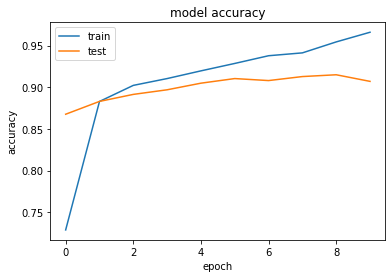

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

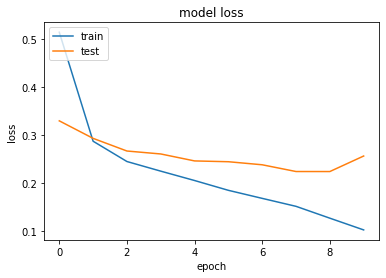

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
# Predict Test
y_pred_final = model.predict_classes(X_final_test)

print(f1_score(y_final_test, y_pred_final))
print(precision_score(y_final_test, y_pred_final))
print(recall_score(y_final_test, y_pred_final))
print(accuracy_score(y_final_test, y_pred_final))
print(confusion_matrix(py_final_test, py_pred_final))

0.664796633941094
0.6652631578947369
0.6643307638402243
0.6323076923076923
[[1392  954]
 [ 958 1896]]


In [ ]:
# Save model
model.save_weights("lstm_model.h5")